In [5]:
import numpy as np
import scipy.signal as sig

# Create training and test data for the NN

# number of random channels that will be trained and tested on
num_train=1000000
num_test=10

# assume we know the channel_length
channel_length = 2
num_preambles = 10
preamble_length = 1000

preambles = np.random.randint(0,2,(num_preambles,preamble_length)) 

# assume we are working with just real parts
channel_train = np.zeros((num_train*num_preambles,channel_length))
preamble_train = np.zeros((num_train*num_preambles, preamble_length))
channel_test = np.zeros((num_test*num_preambles,channel_length))
preamble_test = np.zeros((num_test*num_preambles, preamble_length))

for i in range(0, num_train):
    for k in range(num_preambles):
        channel_train[i+k,:]=np.random.uniform(0.2,1,2)
        # if the total power is greater than 1, then normalize
        if sum(channel_train[i+k])>=1:
            channel_train[i+k] = channel_train[i+k]/(sum(channel_train[i+k]))
        preamble_train[i+k,:] = sig.convolve(preambles[k], channel_train[i+k], mode='same')
        
for i in range(0, num_test):
    for k in range(num_preambles):
        channel_test[i+k,:]=np.random.uniform(0.2,1,2)
        # if the total power is greater than 1, then normalize
        if sum(channel_test[i+k])>=1:
            channel_test[i+k] = channel_test[i+k]/(sum(channel_test[i+k]))
        preamble_test[i+k,:] = sig.convolve(preambles[k], channel_test[i], mode='same')
    

Epoch 0, Cost 0.3728514611721039, MC Cost: 0.040838394314050674
Epoch 100, Cost 3.8231853977777064e-05, MC Cost: 0.014036059379577637
Epoch 200, Cost 1.69208251463715e-05, MC Cost: 0.013782438822090626
Epoch 300, Cost 7.688170626352075e-06, MC Cost: 0.01379319652915001
Epoch 400, Cost 4.226171313348459e-06, MC Cost: 0.013932604342699051
Epoch 500, Cost 2.7686337489285506e-06, MC Cost: 0.014075696468353271
Epoch 600, Cost 2.455155936331721e-06, MC Cost: 0.014167743735015392
Epoch 700, Cost 2.2668698420602595e-06, MC Cost: 0.014212743379175663
Epoch 800, Cost 2.382094862696249e-06, MC Cost: 0.01423008181154728
Epoch 900, Cost 2.1701064270018833e-06, MC Cost: 0.014237063005566597


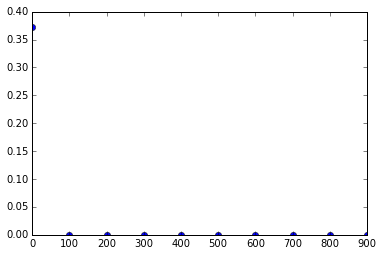

In [4]:
import numpy as np
from numpy import linalg as LA
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
# fix random seed for reproducibility
np.random.seed()

m = 2 # of consecutive taps
learning_rate = 0.001
epochs = 1000
batch_size = 1000
test_averaging=100
decay = 1 - 10*1e-10

num_train = 1000000

# declare the training data placeholders
# input x - just one is x0
real_channel = tf.placeholder(tf.float32, [None, m])
received_preamble = tf.placeholder(tf.float32, [None, preamble_length])

layer_1 = tf.layers.dense(
  received_preamble, 150, tf.nn.tanh, use_bias=True)
layer_2 = tf.layers.dense(
  layer_1, 150, tf.nn.tanh, use_bias=True)
layer_3 = tf.layers.dense(
  layer_2, m, activation=tf.identity, use_bias=True)

estimated_channel = layer_3


adaptive_learning_rate = tf.placeholder_with_default(learning_rate, [])

est_cost = tf.reduce_mean(tf.reduce_mean((real_channel-estimated_channel)**2, axis=1))

optimizer = tf.train.AdamOptimizer(learning_rate=adaptive_learning_rate).minimize(est_cost)
                                                                                  
# finally setup the initialisation operator
init_op = tf.global_variables_initializer()

plt.figure()

# start the session
with tf.Session() as sess:
    #    initialize the variables
    sess.run(init_op)
    mc_losses = []
        
    for epoch in range(epochs):
        
        channel_batch = [1,0]
        identity_channel = np.zeros(channel_length)
        identity_channel[0] = 1
        preamble_batch = sig.convolve(preambles[0], identity_channel, mode='full')[:preamble_length]

        for rand in range(0, batch_size-1):
            rand_int = np.random.randint(0,num_train)
            channel_batch = np.vstack((channel_batch, channel_train[rand_int]))
            preamble_batch = np.vstack((preamble_batch, preamble_train[rand_int]))
            
        channel_batch.reshape((batch_size, m))
        preamble_batch.reshape((batch_size, preamble_length))
        
        _,cost,estimated_channel2 = sess.run([optimizer, est_cost, estimated_channel], 
                                          feed_dict={real_channel: channel_batch, received_preamble: preamble_batch,
                         adaptive_learning_rate: learning_rate * (decay**epoch)})
            
        if epoch % 100 == 0: 
            plt.plot(epoch, cost, 'bo')
            try:
                mc_cost, mc_estimate = sess.run([est_cost, estimated_channel], 
                                                 feed_dict={real_channel: channel_test, 
                                                            received_preamble: preamble_test})
            except Exception as e:
                print(e)
            print('Epoch {}, Cost {}, MC Cost: {}'.format(epoch, cost, mc_cost))

    
plt.show()